## Credit Card Fraud Detection
#### Anonymized credit card transactions labeled as fraudulent or genuine

Inspired by [this](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd) blog post, I wanted to see how a random forest model would stack up against an autoencoder in dealing with unbalanced and anonimized data.



Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

### Imports

In [136]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [138]:
PATH = "data/creditcard/"

### Load  data

In [139]:
df_raw = pd.read_csv(f'{PATH}creditcard.csv')

In [140]:
df_raw.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### EDA

In [141]:
df_raw.shape

(284807, 31)

Lets see how many missing values are in the data set

In [142]:
df_raw.isnull().sum().sort_index()/len(df_raw)

Amount    0.0
Class     0.0
Time      0.0
V1        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V2        0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
dtype: float64

In [143]:
frauds = df_raw[df_raw.Class == 1]

In [144]:
normal = df_raw[df_raw.Class == 0]

In [146]:
frauds.shape, normal.shape

((492, 31), (284315, 31))

In [147]:
frauds.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1


In case of fraud, we would expect to see a highly imbalanced dataset.

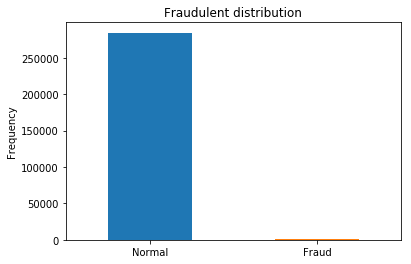

In [148]:
count_classes = pd.value_counts(df_raw['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Fraudulent distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.ylabel("Frequency");

How different are the amount of money used in different transaction classes?

In [149]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [150]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

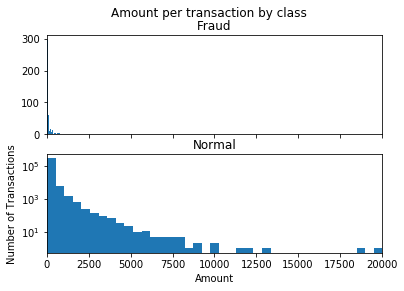

In [151]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50
ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

###  Skiping Feature engineering

## Test and validation set

We should set aside, let's say around 30% of our data for testing.

In [154]:
train = df_raw.sample(frac=0.8, random_state=42)
test = df_raw.drop(train.index)

In [155]:
train.shape

(227846, 31)

In [156]:
test.shape

(56961, 31)

In [157]:
test = test.reset_index()
del test['index']

In [158]:
#Save the test dataframe to disk
os.makedirs('tmp', exist_ok=True)
test.to_feather('tmp/customers_test_set')

Considering this is a small and imbalanced dataset we could oversample the less common class, or use the class_weight parameter in the random forest classifier.

In [159]:
# Divide by class
normal = train[train.Class == 0]
frauds = train[train.Class == 1]
normal.shape, frauds.shape

((227459, 31), (387, 31))

In [160]:
# Class count
count_normal, count_frauds = train.Class.value_counts()
count_normal, count_frauds

(227459, 387)

In [161]:
train_oversampled = frauds.sample(count_normal, replace=True)

In [162]:
df_train_oversampled = pd.concat([normal, train_oversampled], axis=0)

In [163]:
df_train_oversampled.shape

(454918, 31)

We oversample the fraudulent transactions until there are eaqal to number of normal transactions

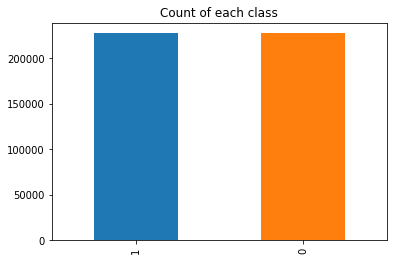

In [164]:
df_train_oversampled.Class.value_counts().plot(kind='bar', title='Count of each class');

In [165]:
train = train.reset_index()
del train['index']

In [166]:
# save our work so far to disk
os.makedirs('tmp', exist_ok=True)
train.to_feather('tmp/customers_train_set')

## Pre-processing

In [167]:
df_raw = pd.read_feather('tmp/customers_train_set')

In [168]:
df_test = pd.read_feather('tmp/customers_test_set')

In [169]:
df_raw.shape, df_test.shape

((227846, 31), (56961, 31))

proc_df will replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [170]:
df, y, nas = proc_df(df_raw, 'Class')

In [171]:
df.shape, y.shape

((227846, 30), (227846,))

### Validation set

We'll grab the validation set from the end of our training set

In [172]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 65000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((162846, 30), (162846,), (65000, 30))

Metrics:

In [ ]:
print(f1_score(actual, preds))
print(recall_score(actual, preds)) 
conf_matrix = confusion_matrix(actual, preds)

In [211]:
def print_score(m):
    res = [f1_score(y_train, m.predict(X_train)), f1_score(y_valid, m.predict(X_valid)),
                recall_score(y_train, m.predict(X_train)), recall_score(y_valid, m.predict(X_valid))]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Fitting the Random Forest

In [189]:
set_rf_samples(20000)

In [179]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(df_trn, y_trn)
print_score(m)

Wall time: 3.06 s
[0.7689075630252102, 0.77, 0.6727941176470589, 0.6695652173913044, 0.9992889934429395]


In [190]:
m = RandomForestClassifier(n_estimators=80, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(df_trn, y_trn)
print_score(m)

Wall time: 14 s
[0.8259109311740892, 0.8476190476190476, 0.75, 0.7739130434782608, 0.9994118834651475]


In [191]:
m = RandomForestClassifier(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(df_trn, y_trn)
print_score(m)

Wall time: 13.2 s
[0.8, 0.8093023255813954, 0.7426470588235294, 0.7565217391304347, 0.9993328827365853]


In [199]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.4, n_jobs=-1, oob_score=True)
%time m.fit(df_trn, y_trn)
print_score(m)

Wall time: 14.1 s
[0.8040404040404041, 0.8151658767772512, 0.7316176470588235, 0.7478260869565218, 0.9993504384540435]


In [200]:
reset_rf_samples()

In [201]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(df_trn, y_trn)
print_score(m)

Wall time: 3min 17s
[0.8999999999999999, 0.8962264150943396, 0.8272058823529411, 0.8260869565217391, 0.9995259956286263]


### Feature importance

Data is anonymized, so no real insight can be gained from feature importance. But we can remove less important features to make our model simpler and more robust.
Feature importance is calculated by randomly shuffling each variable and seeing how the predicted accuracy is changing with our pre-trained model.

In [202]:
fi = rf_feat_importance(m, df_trn); fi[:20]

,cols,imp
17,V17,0.333875
12,V12,0.213187
14,V14,0.096669
10,V10,0.093730
11,V11,0.030976
26,V26,0.023861
16,V16,0.020066
4,V4,0.016567
7,V7,0.016272
0,Time,0.015946


In [203]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

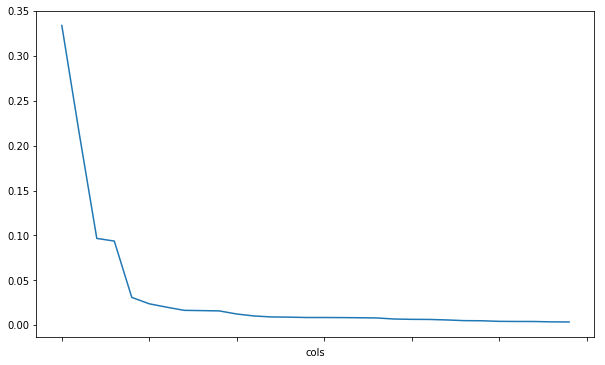

In [204]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

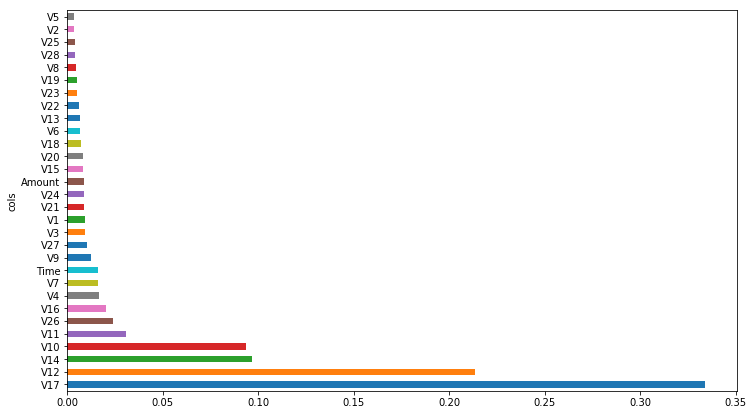

In [205]:
plot_fi(fi[:30]);

### Removing redundant features

In [206]:
to_keep = fi[fi.imp>0.007310].cols; len(to_keep)

19

In [207]:
df_keep = df_trn[to_keep].copy()

In [208]:
df_keep.shape, y_trn.shape

((227846, 19), (227846,))

In [213]:
def print_score(m):
    res = [m.score(df_keep, y_trn)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [214]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(df_keep, y_trn)
print_score(m)

Wall time: 1min 49s
[0.9996752192270217, 0.99953916241672]


We can see that by removing some features our accuracy hasn't gotten worse, so it's safe to say that these features were not important.

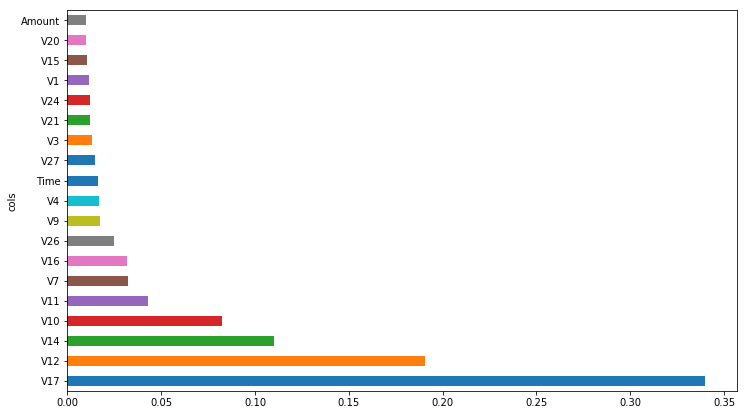

In [215]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [216]:
from scipy.cluster import hierarchy as hc

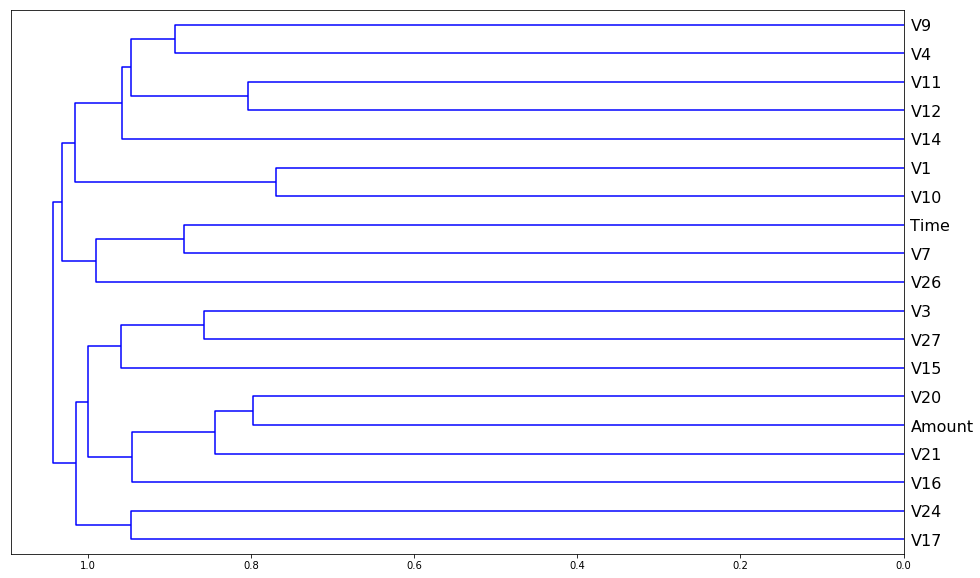

In [217]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

With rank correlation, we can see that the there are no highly correlated features

A more closer look at the Amount feature

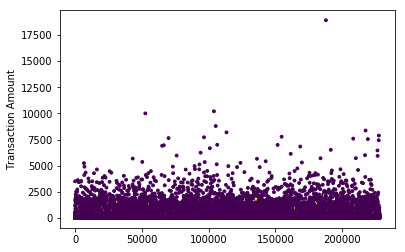

In [218]:
plt.scatter(df_raw.index, df_raw.Amount, s=8, c=df_raw.Class);
plt.ylabel('Transaction Amount');

There are some outliers in the fraudlent category

### Test data

In [219]:
df_test = pd.read_feather('tmp/customers_test_set')

In [220]:
df_test.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
1,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0
2,10.0,1.449044,-1.176339,0.913860,-1.375667,-1.971383,-0.629152,-1.423236,0.048456,-1.720408,...,-0.009302,0.313894,0.027740,0.500512,0.251367,-0.129478,0.042850,0.016253,7.80,0


In [221]:
df_test.shape

(56961, 31)

In [222]:
df, y, nas = proc_df(df_test, 'Class', na_dict=nas )

In [126]:
keeping = df_keep.columns

In [127]:
keeping

Index(['V17', 'V12', 'V14', 'V10', 'V26', 'V7', 'V11', 'V16', 'V21', 'Time',
       'V9', 'V4', 'V18', 'V27', 'V3', 'Amount', 'V13', 'V15', 'V1', 'V24'],
      dtype='object')

In [128]:
df_test = df_test[keeping]

### Evaluate the random forest on the test set:

In [129]:
preds = m.predict(df_test)

In [130]:
df_actual = pd.read_feather('tmp/customers_test_set')

In [131]:
actual = df_actual['Class']

In [132]:
m.score(df_test, actual)

0.9995435473394076

In [133]:
print(f1_score(actual, preds))
print(recall_score(actual, preds)) 

0.8700000000000001
0.8285714285714286


In [134]:
conf_matrix = confusion_matrix(actual, preds)

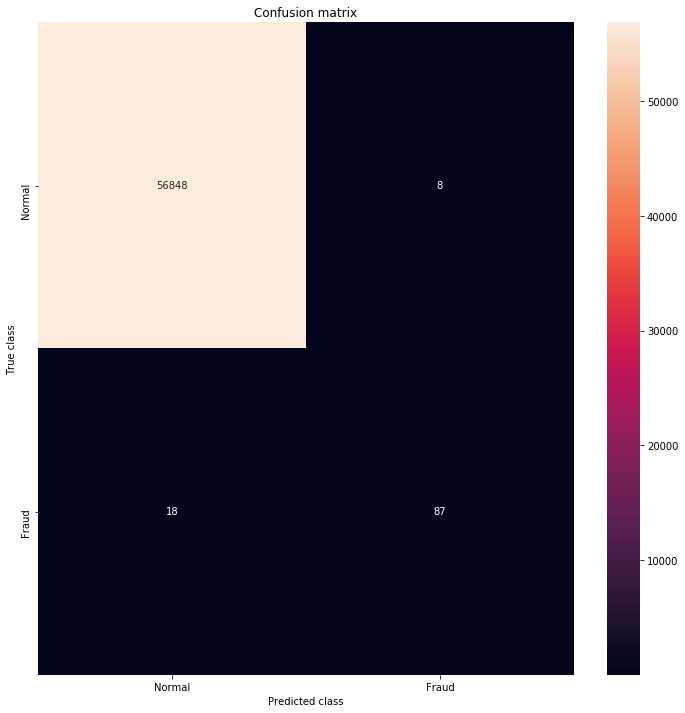

In [135]:
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Summary

A random forest model without any feature engineering seems to outperform anomaly detection approach using [a simple Deep Autoencoder](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)